# Bagging and Out-of-Bag Evaluation

## Overview

**Bagging** (Bootstrap AGGregating) is an ensemble method that improves model stability and accuracy by:
1. Creating multiple bootstrap samples of the training data
2. Training a separate model on each sample
3. Aggregating predictions (voting for classification, averaging for regression)

## Key Concepts

### Bootstrap Sampling

- Draw \(n\) samples **with replacement** from training set of size \(n\)
- Each bootstrap sample contains ~63.2% unique samples
- Remaining ~36.8% are "out-of-bag" (OOB) samples

### Why Bagging Works

**Variance Reduction**: If we have \(B\) independent models with variance \(\sigma^2\), the ensemble variance is:

\[
\text{Var}(\text{ensemble}) = \frac{\sigma^2}{B}
\]

In practice, models are correlated, so:

\[
\text{Var}(\text{ensemble}) = \rho\sigma^2 + \frac{1-\rho}{B}\sigma^2
\]

where \(\rho\) is the correlation between models.

**Key Insight**: Bagging reduces variance (overfitting) without increasing bias!

### Out-of-Bag (OOB) Evaluation

- Each sample is OOB for ~37% of models
- Can evaluate each sample using only models that didn't see it
- Provides unbiased error estimate without separate validation set
- Similar to cross-validation but "free"

## Topics Covered

1. BaggingClassifier and BaggingRegressor
2. Bootstrap sampling mechanics
3. Out-of-Bag scoring
4. Random Forests as specialized bagging
5. Hyperparameter tuning
6. When to use bagging

## Setup and Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensemble methods
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, RandomForestClassifier, RandomForestRegressor

# Base estimators
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Utilities
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.datasets import make_classification, make_regression, load_wine, load_diabetes, load_breast_cancer

np.random.seed(42)
sns.set_style('whitegrid')
print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 1. Understanding Bootstrap Sampling

### 1.1 Bootstrap Mechanics

In [2]:
print("Bootstrap Sampling Demonstration")
print("="*70)

# Simple dataset
original_data = np.arange(10)
n_samples = len(original_data)

print(f"Original dataset: {original_data}")
print(f"Size: {n_samples}\n")

# Create bootstrap samples
n_bootstrap = 5
for i in range(n_bootstrap):
    # Sample with replacement
    bootstrap_sample = np.random.choice(original_data, size=n_samples, replace=True)
    
    # Find unique samples and OOB samples
    unique_samples = np.unique(bootstrap_sample)
    oob_samples = np.setdiff1d(original_data, bootstrap_sample)
    
    print(f"Bootstrap {i+1}: {bootstrap_sample}")
    print(f"  Unique: {unique_samples} ({len(unique_samples)}/{n_samples} = {len(unique_samples)/n_samples:.1%})")
    print(f"  OOB:    {oob_samples} ({len(oob_samples)}/{n_samples} = {len(oob_samples)/n_samples:.1%})")
    print()

Bootstrap Sampling Demonstration
Original dataset: [0 1 2 3 4 5 6 7 8 9]
Size: 10

Bootstrap 1: [6 3 7 4 6 9 2 6 7 4]
  Unique: [2 3 4 6 7 9] (6/10 = 60.0%)
  OOB:    [0 1 5 8] (4/10 = 40.0%)

Bootstrap 2: [3 7 7 2 5 4 1 7 5 1]
  Unique: [1 2 3 4 5 7] (6/10 = 60.0%)
  OOB:    [0 6 8 9] (4/10 = 40.0%)

Bootstrap 3: [4 0 9 5 8 0 9 2 6 3]
  Unique: [0 2 3 4 5 6 8 9] (8/10 = 80.0%)
  OOB:    [1 7] (2/10 = 20.0%)

Bootstrap 4: [8 2 4 2 6 4 8 6 1 3]
  Unique: [1 2 3 4 6 8] (6/10 = 60.0%)
  OOB:    [0 5 7 9] (4/10 = 40.0%)

Bootstrap 5: [8 1 9 8 9 4 1 3 6 7]
  Unique: [1 3 4 6 7 8 9] (7/10 = 70.0%)
  OOB:    [0 2 5] (3/10 = 30.0%)



Theoretical Analysis
n=  10: P(in sample) = 0.6513, P(OOB) = 0.3487
n=  50: P(in sample) = 0.6358, P(OOB) = 0.3642
n= 100: P(in sample) = 0.6340, P(OOB) = 0.3660
n= 500: P(in sample) = 0.6325, P(OOB) = 0.3675
n=1000: P(in sample) = 0.6323, P(OOB) = 0.3677

Limit (n→∞): P(OOB) = 1/e = 0.3679 ≈ 36.8%
             P(in sample) = 1 - 1/e = 0.6321 ≈ 63.2%


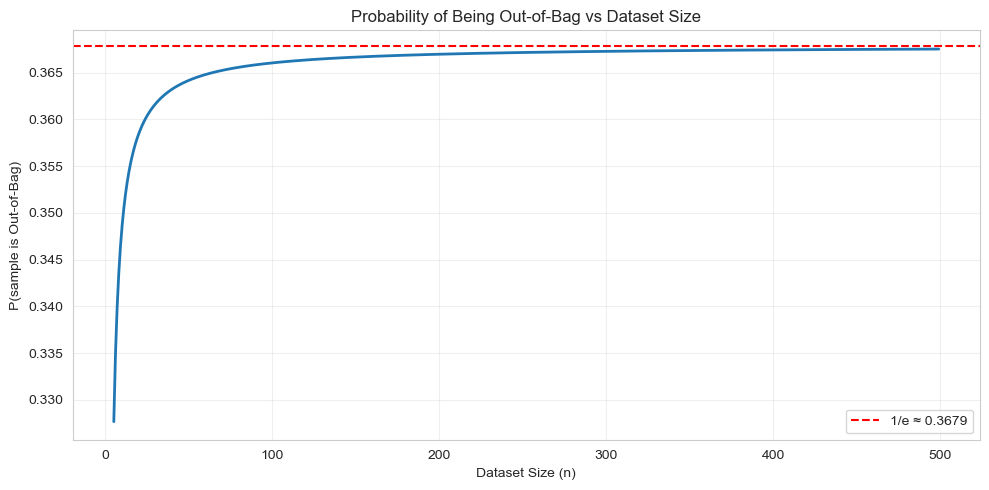


💡 Key Takeaway: ~37% of samples are OOB for each bootstrap sample


In [3]:
# Theoretical probability of being in bootstrap sample
print("Theoretical Analysis")
print("="*70)

# Probability of NOT being selected in one draw: (n-1)/n
# Probability of NOT being selected in n draws: ((n-1)/n)^n
# As n → ∞, this approaches 1/e ≈ 0.368

n_values = [10, 50, 100, 500, 1000]
for n in n_values:
    prob_not_selected = ((n-1)/n)**n
    prob_selected = 1 - prob_not_selected
    print(f"n={n:4d}: P(in sample) = {prob_selected:.4f}, P(OOB) = {prob_not_selected:.4f}")

print(f"\nLimit (n→∞): P(OOB) = 1/e = {1/np.e:.4f} ≈ 36.8%")
print(f"             P(in sample) = 1 - 1/e = {1 - 1/np.e:.4f} ≈ 63.2%")

# Visualize
n_range = np.arange(5, 500)
prob_oob = ((n_range - 1) / n_range) ** n_range

plt.figure(figsize=(10, 5))
plt.plot(n_range, prob_oob, linewidth=2)
plt.axhline(y=1/np.e, color='r', linestyle='--', label=f'1/e ≈ {1/np.e:.4f}')
plt.xlabel('Dataset Size (n)')
plt.ylabel('P(sample is Out-of-Bag)')
plt.title('Probability of Being Out-of-Bag vs Dataset Size')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 Key Takeaway: ~37% of samples are OOB for each bootstrap sample")

## 2. BaggingClassifier

### 2.1 Basic Usage

In [4]:
# Load wine dataset
wine = load_wine()
X_wine = wine.data
y_wine = wine.target

print("Wine Classification Dataset")
print("="*70)
print(f"Samples: {X_wine.shape[0]}")
print(f"Features: {X_wine.shape[1]}")
print(f"Classes: {len(wine.target_names)} - {wine.target_names}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_wine, y_wine, test_size=0.3, random_state=42, stratify=y_wine
)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Wine Classification Dataset
Samples: 178
Features: 13
Classes: 3 - ['class_0' 'class_1' 'class_2']

Train set: 124 samples
Test set: 54 samples


In [5]:
print("\nSingle Decision Tree vs Bagging")
print("="*70)

# Single decision tree (prone to overfitting)
single_tree = DecisionTreeClassifier(random_state=42)
single_tree.fit(X_train, y_train)

train_acc_single = single_tree.score(X_train, y_train)
test_acc_single = single_tree.score(X_test, y_test)

print(f"Single Decision Tree:")
print(f"  Train Accuracy: {train_acc_single:.4f}")
print(f"  Test Accuracy:  {test_acc_single:.4f}")
print(f"  Overfitting:    {train_acc_single - test_acc_single:.4f}")

# Bagging ensemble
bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=100,
    max_samples=1.0,  # Use 100% of training data for each bootstrap
    max_features=1.0,  # Use 100% of features
    bootstrap=True,
    oob_score=True,  # Enable OOB scoring
    random_state=42,
    n_jobs=-1
)

bagging.fit(X_train, y_train)

train_acc_bagging = bagging.score(X_train, y_train)
test_acc_bagging = bagging.score(X_test, y_test)
oob_acc_bagging = bagging.oob_score_

print(f"\nBagging (100 trees):")
print(f"  Train Accuracy: {train_acc_bagging:.4f}")
print(f"  Test Accuracy:  {test_acc_bagging:.4f}")
print(f"  OOB Accuracy:   {oob_acc_bagging:.4f}")
print(f"  Overfitting:    {train_acc_bagging - test_acc_bagging:.4f}")

print(f"\n✓ Improvement: {test_acc_bagging - test_acc_single:.4f} ({(test_acc_bagging/test_acc_single - 1)*100:.1f}%)")
print(f"✓ Reduced overfitting: {(train_acc_single - test_acc_single) - (train_acc_bagging - test_acc_bagging):.4f}")


Single Decision Tree vs Bagging
Single Decision Tree:
  Train Accuracy: 1.0000
  Test Accuracy:  0.9630
  Overfitting:    0.0370

Bagging (100 trees):
  Train Accuracy: 1.0000
  Test Accuracy:  1.0000
  OOB Accuracy:   0.9355
  Overfitting:    0.0000

✓ Improvement: 0.0370 (3.8%)
✓ Reduced overfitting: 0.0370


### 2.2 Out-of-Bag (OOB) Evaluation

In [6]:
print("Out-of-Bag Evaluation")
print("="*70)

print(f"\nOOB Score: {oob_acc_bagging:.4f}")
print(f"Test Score: {test_acc_bagging:.4f}")
print(f"Difference: {abs(oob_acc_bagging - test_acc_bagging):.4f}")

print(f"\n💡 OOB score approximates test performance without using test set!")
print(f"   Each training sample is evaluated only by models that didn't see it.")
print(f"   This provides unbiased error estimate for model selection.")

# OOB decision function (probability estimates)
oob_decision = bagging.oob_decision_function_
print(f"\nOOB decision function shape: {oob_decision.shape}")
print(f"  (samples × classes) = ({oob_decision.shape[0]} × {oob_decision.shape[1]})")

# Show example OOB predictions
print(f"\nExample OOB predictions (first 5 samples):")
for i in range(5):
    true_class = y_train[i]
    pred_class = np.argmax(oob_decision[i])
    probs = oob_decision[i]
    print(f"  Sample {i}: True={true_class}, Pred={pred_class}, Probs={probs}")

Out-of-Bag Evaluation

OOB Score: 0.9355
Test Score: 1.0000
Difference: 0.0645

💡 OOB score approximates test performance without using test set!
   Each training sample is evaluated only by models that didn't see it.
   This provides unbiased error estimate for model selection.

OOB decision function shape: (124, 3)
  (samples × classes) = (124 × 3)

Example OOB predictions (first 5 samples):
  Sample 0: True=0, Pred=0, Probs=[0.96774194 0.03225806 0.        ]
  Sample 1: True=0, Pred=0, Probs=[0.97142857 0.02857143 0.        ]
  Sample 2: True=0, Pred=0, Probs=[0.96774194 0.03225806 0.        ]
  Sample 3: True=0, Pred=0, Probs=[1. 0. 0.]
  Sample 4: True=1, Pred=1, Probs=[0.03125 0.9375  0.03125]


### 2.3 Effect of Number of Estimators

Effect of Number of Estimators
n=  1: Train=0.9435, Test=0.8704, OOB=0.5565


/opt/anaconda3/lib/python3.13/site-packages/sklearn/ensemble/_bagging.py:865: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/ensemble/_bagging.py:871: RuntimeWarning: invalid value encountered in divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
Exception ignored in: <function ResourceTracker.__del__ at 0x102f6d8a0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 84, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 93, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 118, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102b3d8a0>
Traceback (most recent call last):
  File "/opt/

n=  5: Train=0.9919, Test=0.9815, OOB=0.8065


Exception ignored in: <function ResourceTracker.__del__ at 0x105fd98a0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 84, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 93, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 118, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10886d8a0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 84, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 93, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 118, in _stop_locked
ChildProcessError: [Errno 10] No child processes


n= 10: Train=0.9919, Test=0.9815, OOB=0.8629
n= 20: Train=1.0000, Test=1.0000, OOB=0.9113
n= 50: Train=1.0000, Test=1.0000, OOB=0.9355
n=100: Train=1.0000, Test=1.0000, OOB=0.9355
n=200: Train=1.0000, Test=1.0000, OOB=0.9435
n=500: Train=1.0000, Test=1.0000, OOB=0.9355


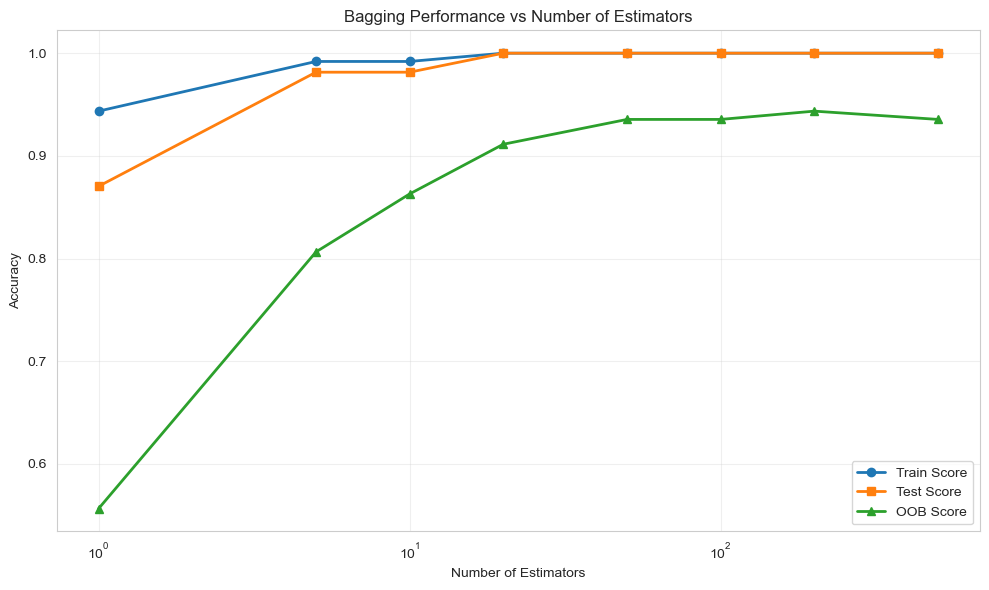


💡 Observations:
   - Performance improves quickly, then plateaus
   - More estimators = more stable but diminishing returns
   - OOB score closely tracks test score
   - Typically 50-200 estimators is sufficient


In [7]:
print("Effect of Number of Estimators")
print("="*70)

n_estimators_range = [1, 5, 10, 20, 50, 100, 200, 500]
train_scores = []
test_scores = []
oob_scores = []

for n_est in n_estimators_range:
    bag = BaggingClassifier(
        estimator=DecisionTreeClassifier(),
        n_estimators=n_est,
        oob_score=True,
        random_state=42,
        n_jobs=-1
    )
    bag.fit(X_train, y_train)
    
    train_scores.append(bag.score(X_train, y_train))
    test_scores.append(bag.score(X_test, y_test))
    oob_scores.append(bag.oob_score_)
    
    print(f"n={n_est:3d}: Train={train_scores[-1]:.4f}, Test={test_scores[-1]:.4f}, OOB={oob_scores[-1]:.4f}")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_scores, 'o-', label='Train Score', linewidth=2)
plt.plot(n_estimators_range, test_scores, 's-', label='Test Score', linewidth=2)
plt.plot(n_estimators_range, oob_scores, '^-', label='OOB Score', linewidth=2)
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Bagging Performance vs Number of Estimators')
plt.legend()
plt.grid(alpha=0.3)
plt.xscale('log')
plt.tight_layout()
plt.show()

print("\n💡 Observations:")
print("   - Performance improves quickly, then plateaus")
print("   - More estimators = more stable but diminishing returns")
print("   - OOB score closely tracks test score")
print("   - Typically 50-200 estimators is sufficient")

## 3. BaggingRegressor

### 3.1 Regression Example

In [8]:
# Load diabetes dataset
diabetes = load_diabetes()
X_diabetes = diabetes.data
y_diabetes = diabetes.target

print("Diabetes Regression Dataset")
print("="*70)
print(f"Samples: {X_diabetes.shape[0]}")
print(f"Features: {X_diabetes.shape[1]}")

# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_diabetes, y_diabetes, test_size=0.2, random_state=42
)

# Single tree
single_tree_reg = DecisionTreeRegressor(random_state=42)
single_tree_reg.fit(X_train_reg, y_train_reg)

y_pred_single = single_tree_reg.predict(X_test_reg)
r2_single = r2_score(y_test_reg, y_pred_single)
rmse_single = np.sqrt(mean_squared_error(y_test_reg, y_pred_single))

print(f"\nSingle Decision Tree:")
print(f"  R² Score: {r2_single:.4f}")
print(f"  RMSE:     {rmse_single:.2f}")

# Bagging regressor
bagging_reg = BaggingRegressor(
    estimator=DecisionTreeRegressor(),
    n_estimators=100,
    oob_score=True,
    random_state=42,
    n_jobs=-1
)

bagging_reg.fit(X_train_reg, y_train_reg)

y_pred_bagging = bagging_reg.predict(X_test_reg)
r2_bagging = r2_score(y_test_reg, y_pred_bagging)
rmse_bagging = np.sqrt(mean_squared_error(y_test_reg, y_pred_bagging))

print(f"\nBagging (100 trees):")
print(f"  R² Score: {r2_bagging:.4f}")
print(f"  RMSE:     {rmse_bagging:.2f}")
print(f"  OOB R²:   {bagging_reg.oob_score_:.4f}")

print(f"\n✓ Improvement:")
print(f"  R² increase: {r2_bagging - r2_single:.4f}")
print(f"  RMSE decrease: {rmse_single - rmse_bagging:.2f}")

Diabetes Regression Dataset
Samples: 442
Features: 10

Single Decision Tree:
  R² Score: 0.0607
  RMSE:     70.55

Bagging (100 trees):
  R² Score: 0.4393
  RMSE:     54.51
  OOB R²:   0.4502

✓ Improvement:
  R² increase: 0.3786
  RMSE decrease: 16.04


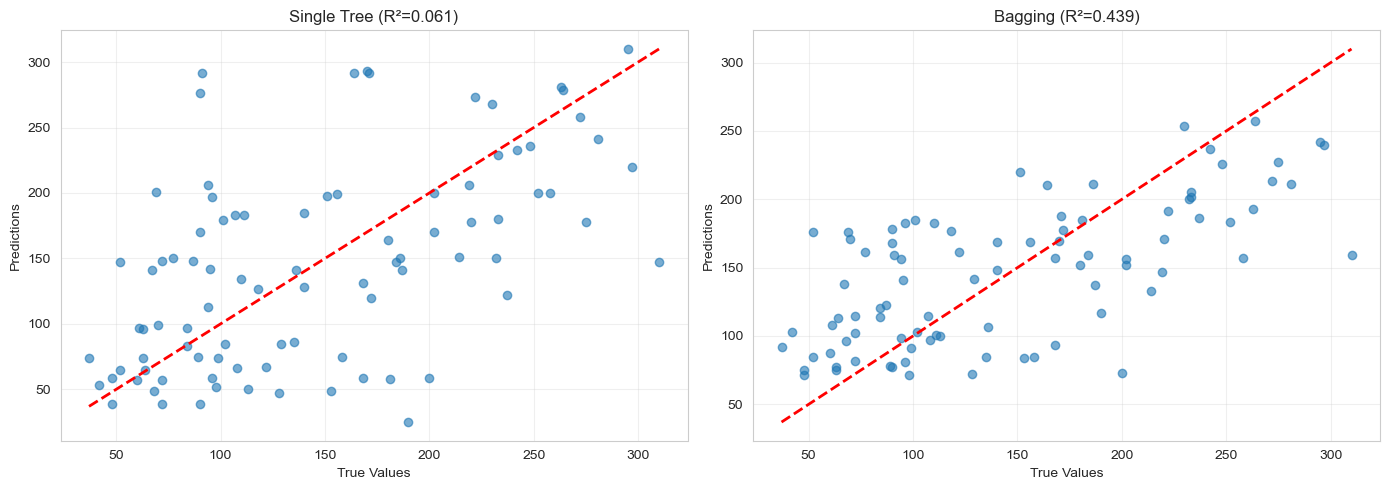

💡 Notice: Bagging produces smoother, more stable predictions


In [9]:
# Visualize predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Single tree
axes[0].scatter(y_test_reg, y_pred_single, alpha=0.6)
axes[0].plot([y_test_reg.min(), y_test_reg.max()], 
             [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
axes[0].set_xlabel('True Values')
axes[0].set_ylabel('Predictions')
axes[0].set_title(f'Single Tree (R²={r2_single:.3f})')
axes[0].grid(alpha=0.3)

# Bagging
axes[1].scatter(y_test_reg, y_pred_bagging, alpha=0.6)
axes[1].plot([y_test_reg.min(), y_test_reg.max()], 
             [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
axes[1].set_xlabel('True Values')
axes[1].set_ylabel('Predictions')
axes[1].set_title(f'Bagging (R²={r2_bagging:.3f})')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 Notice: Bagging produces smoother, more stable predictions")

## 4. Different Base Estimators

### 4.1 Bagging with Various Models

In [10]:
print("Bagging with Different Base Estimators")
print("="*70)

# Load breast cancer for binary classification
cancer = load_breast_cancer()
X_cancer = cancer.data
y_cancer = cancer.target

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_cancer, y_cancer, test_size=0.2, random_state=42, stratify=y_cancer
)

# Standardize for non-tree models
scaler = StandardScaler()
X_train_c_scaled = scaler.fit_transform(X_train_c)
X_test_c_scaled = scaler.transform(X_test_c)

base_estimators = {
    'Decision Tree': DecisionTreeClassifier(max_depth=5),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
}

results = []

for name, base_est in base_estimators.items():
    # Use scaled data for non-tree models
    X_tr = X_train_c if 'Tree' in name else X_train_c_scaled
    X_te = X_test_c if 'Tree' in name else X_test_c_scaled
    
    # Single model
    base_est.fit(X_tr, y_train_c)
    single_score = base_est.score(X_te, y_test_c)
    
    # Bagging
    bagging = BaggingClassifier(
        estimator=base_est,
        n_estimators=50,
        oob_score=True,
        random_state=42,
        n_jobs=-1
    )
    bagging.fit(X_tr, y_train_c)
    bagging_score = bagging.score(X_te, y_test_c)
    oob_score = bagging.oob_score_
    
    improvement = bagging_score - single_score
    
    results.append({
        'Base Estimator': name,
        'Single': single_score,
        'Bagging': bagging_score,
        'OOB': oob_score,
        'Improvement': improvement
    })
    
    print(f"\n{name}:")
    print(f"  Single:      {single_score:.4f}")
    print(f"  Bagging:     {bagging_score:.4f}")
    print(f"  OOB:         {oob_score:.4f}")
    print(f"  Improvement: {improvement:+.4f}")

results_df = pd.DataFrame(results)
print("\n" + "="*70)
print("Summary:")
print(results_df.to_string(index=False))

print("\n💡 Observations:")
print("   - Bagging helps most with unstable models (trees, KNN)")
print("   - Stable models (logistic regression) see less benefit")
print("   - Always test if bagging improves your specific case!")

Bagging with Different Base Estimators

Decision Tree:
  Single:      0.9211
  Bagging:     0.9386
  OOB:         0.9516
  Improvement: +0.0175

Logistic Regression:
  Single:      0.9825
  Bagging:     0.9825
  OOB:         0.9846
  Improvement: +0.0000

KNN (k=5):
  Single:      0.9561
  Bagging:     0.9737
  OOB:         0.9670
  Improvement: +0.0175

Summary:
     Base Estimator   Single  Bagging      OOB  Improvement
      Decision Tree 0.921053 0.938596 0.951648     0.017544
Logistic Regression 0.982456 0.982456 0.984615     0.000000
          KNN (k=5) 0.956140 0.973684 0.967033     0.017544

💡 Observations:
   - Bagging helps most with unstable models (trees, KNN)
   - Stable models (logistic regression) see less benefit
   - Always test if bagging improves your specific case!


## 5. Hyperparameter Tuning

### 5.1 Key Parameters

In [11]:
print("Bagging Hyperparameters")
print("="*70)

print("""
Key Parameters:

1. n_estimators: Number of base models
   - More is usually better (diminishing returns)
   - Typical: 50-500

2. max_samples: Samples per bootstrap (int or float)
   - Default: 1.0 (100% of training data)
   - Lower values: More diversity, faster training
   - Range: 0.5-1.0

3. max_features: Features per model (int or float)
   - Default: 1.0 (all features)
   - Lower values: More diversity (like Random Forest)
   - Range: 0.5-1.0 or sqrt(n_features)

4. bootstrap: Sample with replacement
   - Default: True
   - False = Pasting (without replacement)

5. oob_score: Use out-of-bag samples for evaluation
   - Only works with bootstrap=True
   - Provides free validation estimate

6. bootstrap_features: Sample features with replacement
   - Default: False
   - True: Random subspace method
""")

Bagging Hyperparameters

Key Parameters:

1. n_estimators: Number of base models
   - More is usually better (diminishing returns)
   - Typical: 50-500

2. max_samples: Samples per bootstrap (int or float)
   - Default: 1.0 (100% of training data)
   - Lower values: More diversity, faster training
   - Range: 0.5-1.0

3. max_features: Features per model (int or float)
   - Default: 1.0 (all features)
   - Lower values: More diversity (like Random Forest)
   - Range: 0.5-1.0 or sqrt(n_features)

4. bootstrap: Sample with replacement
   - Default: True
   - False = Pasting (without replacement)

5. oob_score: Use out-of-bag samples for evaluation
   - Only works with bootstrap=True
   - Provides free validation estimate

6. bootstrap_features: Sample features with replacement
   - Default: False
   - True: Random subspace method




Effect of max_samples
max_samples=0.3: Test=0.9815, OOB=0.9516
max_samples=0.5: Test=1.0000, OOB=0.9516
max_samples=0.7: Test=1.0000, OOB=0.9516
max_samples=0.9: Test=1.0000, OOB=0.9355
max_samples=1.0: Test=1.0000, OOB=0.9355


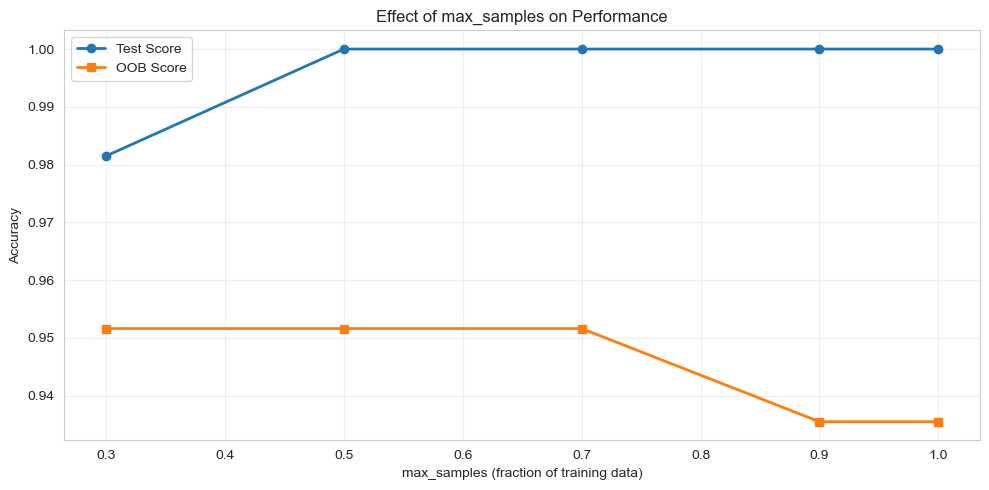

In [12]:
print("\nEffect of max_samples")
print("="*70)

max_samples_values = [0.3, 0.5, 0.7, 0.9, 1.0]
scores_by_samples = []

for max_samp in max_samples_values:
    bag = BaggingClassifier(
        estimator=DecisionTreeClassifier(),
        n_estimators=100,
        max_samples=max_samp,
        oob_score=True,
        random_state=42,
        n_jobs=-1
    )
    bag.fit(X_train, y_train)
    
    test_score = bag.score(X_test, y_test)
    oob_score = bag.oob_score_
    
    scores_by_samples.append({
        'max_samples': max_samp,
        'test_score': test_score,
        'oob_score': oob_score
    })
    
    print(f"max_samples={max_samp:.1f}: Test={test_score:.4f}, OOB={oob_score:.4f}")

# Plot
df_samples = pd.DataFrame(scores_by_samples)
plt.figure(figsize=(10, 5))
plt.plot(df_samples['max_samples'], df_samples['test_score'], 'o-', label='Test Score', linewidth=2)
plt.plot(df_samples['max_samples'], df_samples['oob_score'], 's-', label='OOB Score', linewidth=2)
plt.xlabel('max_samples (fraction of training data)')
plt.ylabel('Accuracy')
plt.title('Effect of max_samples on Performance')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Random Forest as Specialized Bagging

### 6.1 Bagging vs Random Forest

In [13]:
print("Bagging vs Random Forest")
print("="*70)

# Standard Bagging
bagging_standard = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=100,
    max_features=1.0,  # All features
    oob_score=True,
    random_state=42,
    n_jobs=-1
)

# Bagging with feature subsampling (like RF)
bagging_feature_sampling = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=100,
    max_features=int(np.sqrt(X_train.shape[1])),  # sqrt(n_features)
    oob_score=True,
    random_state=42,
    n_jobs=-1
)

# Random Forest
rf = RandomForestClassifier(
    n_estimators=100,
    max_features='sqrt',
    oob_score=True,
    random_state=42,
    n_jobs=-1
)

models = {
    'Bagging (all features)': bagging_standard,
    'Bagging (sqrt features)': bagging_feature_sampling,
    'Random Forest': rf
}

for name, model in models.items():
    model.fit(X_train, y_train)
    test_score = model.score(X_test, y_test)
    oob_score = model.oob_score_
    
    print(f"\n{name}:")
    print(f"  Test Score: {test_score:.4f}")
    print(f"  OOB Score:  {oob_score:.4f}")

print("\n" + "="*70)
print("Key Differences:")
print("""
Bagging:
  - Uses all features for each split
  - Bootstrap samples only
  - Can use any base estimator

Random Forest:
  - Samples features at each split (random subspace)
  - Bootstrap samples + feature sampling
  - Optimized for decision trees
  - Often better than standard bagging
  - Additional optimizations (faster, better splitting)
""")

Bagging vs Random Forest

Bagging (all features):
  Test Score: 1.0000
  OOB Score:  0.9355

Bagging (sqrt features):
  Test Score: 1.0000
  OOB Score:  0.9758

Random Forest:
  Test Score: 1.0000
  OOB Score:  0.9758

Key Differences:

Bagging:
  - Uses all features for each split
  - Bootstrap samples only
  - Can use any base estimator

Random Forest:
  - Samples features at each split (random subspace)
  - Bootstrap samples + feature sampling
  - Optimized for decision trees
  - Often better than standard bagging
  - Additional optimizations (faster, better splitting)



## 7. When to Use Bagging

### 7.1 Decision Guide

In [14]:
print("When to Use Bagging")
print("="*70)

guide = """
✓ USE BAGGING when:
  1. Base model has high variance (overfits)
     - Deep decision trees
     - Neural networks
     - KNN with small k
  
  2. You want to reduce overfitting
     - Single model: high train, low test accuracy
  
  3. You can train models in parallel
     - Bagging is embarrassingly parallel
  
  4. You need probability estimates
     - Averaging produces smooth probabilities
  
  5. You want "free" validation (OOB)
     - No need for separate validation set

✗ DON'T USE BAGGING when:
  1. Base model is already stable
     - Linear regression
     - Logistic regression with regularization
     - Small decision trees with max_depth
  
  2. Model has high bias (underfits)
     - Bagging reduces variance, not bias
     - Use boosting instead
  
  3. Interpretability is critical
     - Ensemble is harder to interpret than single model
  
  4. Training time is severely limited
     - Must train n_estimators models
  
  5. Memory is constrained
     - Must store n_estimators models

⚡ ALTERNATIVES:
  - Boosting (AdaBoost, GradientBoosting): High bias problems
  - Random Forest: Usually better than plain bagging for trees
  - Stacking: Combine different model types
  - Regularization: Single model with better generalization
"""

print(guide)

When to Use Bagging

✓ USE BAGGING when:
  1. Base model has high variance (overfits)
     - Deep decision trees
     - Neural networks
     - KNN with small k
  
  2. You want to reduce overfitting
     - Single model: high train, low test accuracy
  
  3. You can train models in parallel
     - Bagging is embarrassingly parallel
  
  4. You need probability estimates
     - Averaging produces smooth probabilities
  
  5. You want "free" validation (OOB)
     - No need for separate validation set

✗ DON'T USE BAGGING when:
  1. Base model is already stable
     - Linear regression
     - Logistic regression with regularization
     - Small decision trees with max_depth
  
  2. Model has high bias (underfits)
     - Bagging reduces variance, not bias
     - Use boosting instead
  
  3. Interpretability is critical
     - Ensemble is harder to interpret than single model
  
  4. Training time is severely limited
     - Must train n_estimators models
  
  5. Memory is constrained
     - 

## Summary and Best Practices

### Quick Reference

```python
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.tree import DecisionTreeClassifier

# Classification
bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(),  # Base model
    n_estimators=100,                     # Number of models
    max_samples=1.0,                      # Samples per bootstrap
    max_features=1.0,                     # Features per model
    bootstrap=True,                       # Sample with replacement
    oob_score=True,                       # Enable OOB scoring
    random_state=42,
    n_jobs=-1                             # Parallel training
)

bagging.fit(X_train, y_train)

# Predictions
y_pred = bagging.predict(X_test)
y_proba = bagging.predict_proba(X_test)

# OOB evaluation (free validation!)
oob_score = bagging.oob_score_
oob_decision = bagging.oob_decision_function_
```

### Key Concepts

1. **Bootstrap Sampling**: ~63% in-bag, ~37% out-of-bag per sample

2. **Variance Reduction**: \(\text{Var}(\text{ensemble}) \approx \frac{\sigma^2}{B}\)

3. **OOB Scoring**: Unbiased error estimate without validation set

4. **Aggregation**: 
   - Classification: Majority vote
   - Regression: Average prediction

### Hyperparameter Guidelines

| Parameter | Typical Range | Effect |
|-----------|---------------|--------|
| `n_estimators` | 50-500 | More = better, diminishing returns |
| `max_samples` | 0.7-1.0 | Lower = more diversity, faster |
| `max_features` | 0.5-1.0 | Lower = more diversity (RF style) |
| `oob_score` | True | Enable for free validation |

### Best Practices

1. ✓ **Start with unstable models** (deep trees, high-variance models)
2. ✓ **Use OOB scoring** for model selection and tuning
3. ✓ **Try 100 estimators** as starting point
4. ✓ **Parallelize training** with `n_jobs=-1`
5. ✓ **Compare with Random Forest** for tree-based models
6. ✓ **Monitor train/test gap** to verify variance reduction

### Common Mistakes

1. ❌ Using bagging with already-stable models
2. ❌ Not enabling `oob_score=True`
3. ❌ Using too few estimators (< 20)
4. ❌ Expecting bias reduction (bagging only reduces variance)
5. ❌ Not comparing with Random Forest for trees

### Bagging Family

```
Bagging Family:
│
├─ BaggingClassifier/Regressor
│   └─ General purpose, any base estimator
│
├─ Random Forest
│   └─ Specialized bagging with feature sampling
│
├─ Extra Trees
│   └─ Random Forest with random thresholds
│
└─ Pasting
    └─ Bagging without replacement (bootstrap=False)
```

### Next Steps

- Random Forest deep dive
- Boosting methods (AdaBoost, Gradient Boosting)
- Stacking and Voting ensembles
- Advanced ensemble techniques
- XGBoost and LightGBM